## Scraping

- 크롤링에 비해 규모가 적다.
- 크롤링은 웹페이지 전체를 가져와야하지만, 스크래핑은 필요한 것만 가져오면 된다.
- 크롤링은 네트워크를 돌아다니지만 스크래핑은 파서를 이용해서 가져온다.
- 크롤링은 데이터를 가지고 와서 Indexing 후 DB에 저장한다.
- 스크래핑은 웹사이트를 스크래퍼를 통해, xml sql excel data로 만든다.


- **결국 우리가 더 자주 쓰일 건 특정 사이트에서 일부를 가져올 Scraping을 더 이용할 것!**
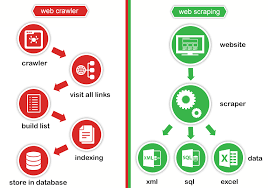

In [1]:
from crawler import download
from bs4 import BeautifulSoup
import bs4
import requests
import time
import re
import sqlite3

In [2]:
con = sqlite3.connect("bot.db")

In [3]:
cur = con.cursor()

In [5]:
cur.executescript('''
    DROP TABLE IF EXISTS table1;
    CREATE TABLE table1 (
        id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE NOT NULL,
        table2_id INTEGER NOT NULL,
        path TEXT NOT NULL,
        param TEXT ,
        depth INTEGER NOT NULL,
        inbound INTEGER NOT NULL,
        seen BOOLEAN DEFAULT "FALSE" NOT NULL,
        date TIMESTAMP DEFAULT CURRENT_TIMESTAMP NOT NULL
        );
''')

cur.executescript('''
    DROP TABLE IF EXISTS table2;
    CREATE TABLE table2 (
        id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE NOT NULL,
        netloc TEXT NOT NULL,
        date TIMESTAMP DEFAULT CURRENT_TIMESTAMP NOT NULL);
''')
con.commit()

In [8]:
# Seed URLs -> DB Insert
url = "https://www.google.com/search"
html = download("get", url, param={'q':'박보영'})
dom2 = BeautifulSoup(html.text, "lxml")

for href in [_.find_parent()["href"]
             for _ in dom2.select(".LC20lb")]:
    
    _urlparse = requests.compat.urlparse(href)
    netloc = "://".join(requests.compat.urlparse(href)[:2])
    cur.execute("SELECT id FROM table2 WHERE netloc=? LIMIT 0,1", [netloc])
    netlocID = cur.fetchone()
    if not netlocID:
        cur.execute("INSERT INTO table2(netloc) VALUES(?)",[netloc])
        con.commit()
        cur.execute("SELECT id FROM table2 WHERE netloc=? LIMIT 0,1", [netloc])
        netlocID = cur.fetchone()
    cur.execute("""
        INSERT INTO 
        table1(table2_id, path, param, depth, inbound)  
        VALUES(?,?,?,?,?)""", 
                [netlocID[0], _urlparse[2], _urlparse[4],1,0])  # inbound가 0이면 seed
    con.commit()
    print(cur.lastrowid, netlocID)

# DB Select Limit 0,1

1 (1,)
2 (1,)
3 (2,)
4 (3,)
5 (4,)
6 (5,)
7 (6,)
8 (6,)


In [13]:
def parseURL(seed):
    
    html = download("get",seed)
    dom = BeautifulSoup(html.text, "lxml")
    
    return [requests.compat.urljoin(url,tag["href"])
            for tag in dom.find_all("a") 
            if tag.has_attr("href") 
            and "javascript:" not in tag["href"]
            and len(tag["href"])>3]

In [15]:
i = 0
while True:
    cur.execute("""
        SELECT table1.id, table2.netloc, table1.path, table1.depth, table1.param, table2.id,table1.inbound
        FROM table1 
        JOIN table2 
            ON table1.table2_id = table2.id 
        WHERE table1.seen = "FALSE" and table1.depth < 3
        ORDER BY table1.date ASC 
        LIMIT 0,1;                   
    """)                        # Limit - # 하나만 가져올 것임_pop이랑 비슷
    seed = cur.fetchone()            # append랑 비슷함
    if not seed or i > 1000:     
        break;
    i+=1    
    cur.execute("""
        UPDATE table1
        SET seen="TRUE"
        WHERE id=?
    """,[seed[0]])
    con.commit()
    
    print(seed)
    
    baseURL = "{0}{1}?{2}".format(seed[1],seed[2],seed[3])
    for href in parseURL(baseURL):
        _urlparse = requests.compat.urlparse(href)
        netloc = "://".join(requests.compat.urlparse(href)[:2])
        cur.execute("SELECT id FROM table2 WHERE netloc=? LIMIT 0,1", [netloc])
        netlocID = cur.fetchone()
        if not netlocID:
            cur.execute("INSERT INTO table2(netloc) VALUES(?)",[netloc])
            con.commit()
            cur.execute("SELECT id FROM table2 WHERE netloc=? LIMIT 0,1", [netloc])
            netlocID = cur.fetchone()
        cur.execute("INSERT INTO table1(table2_id, path, param, depth, inbound) VALUES(?,?,?,?,?)", 
                    [netlocID[0], _urlparse[2], _urlparse[4], seed[5], seed[6]] )
        con.commit()   
        print(cur.lastrowid, netlocID)
 #break

(586, 'javascript://', ';', 2, '', 32, 0)


InvalidSchema: No connection adapters were found for 'javascript://;?2'

In [22]:
url = "http://www.ppomppu.co.kr/zboard/zboard.php"
html = download("get", url, param={"id":"ppomppu"})
dom = BeautifulSoup(html.text, "html.parser")

In [23]:
dom

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html>
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="text/javascript" http-equiv="Content-Script-Type"/>
<meta content="text/css" http-equiv="Content-Style-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="PPOMPPU CO." name="author"/>
<meta content="뽐뿌" name="description"/>
<meta content="" name="keywords"/>
<script async="async" src="//www.googletagservices.com/tag/js/gpt.js"></script>
<script>var googletag = googletag || {};googletag.cmd = googletag.cmd || [];</script>
<!--
<meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0, user-scalable=yes, target-densitydpi=device-dpi" />
-->
<meta content="http://www.ppomppu.co.kr/images/icon_app_20160427.png" property="og:image">
<meta content="뽐뿌" property="og:site_name">
<title>뽐뿌 - 뽐뿌게시판</title><!--<link href='ht

In [62]:
dom.select("tr.list1 td.eng.list_vspace" )

SyntaxError: invalid syntax (<ipython-input-62-c4071e6c483e>, line 1)

In [68]:
dom.select("tr[class^=list]")

[<tr align="center" class="list_notice" id="page_show_noti_1" name="page_show_noti_1" onmouseout="this.style.backgroundColor=''" onmouseover="this.style.backgroundColor='#F5F5F5'" style="height:50;word-break:break-all;display:table-row;*display:block;" valign="middle">
 <td align="center" colspan="2">
 <img alt="notice" border="0" src="/images/notice_icon.jpg"/></td>
 <td class="han list_vspace" colspan="2" nowrap=""><nobr class="han list_vspace">기타</nobr></td>
 <!--<td nowrap colspan=2 style='padding:0'><input type=checkbox name=cart value="6"></td>-->
 <td align="left" class="list_vspace" colspan="2"><div class="list_name" style="width:80px;overflow:hidden;text-overflow:ellipsis"><nobr class="list_vspace"> <a href="#" onclick="return false"><img align="absmiddle" alt="관리자3" border="0" src="//nic.ppomppu.co.kr/zboard/nickcon/157163.gif?v=201907161432"/></a></nobr></div></td> <td align="left" class="list_vspace">
 <a href="view.php?id=regulation&amp;page=1&amp;divpage=202&amp;no=6">[필독

In [73]:
[tag.text for tag in dom.select("tr[class^=list] font")]

['[Gsuite] Gsuite Basic India (3700원(월) / 무료)',
 '[하이마트몰] 갤럭시버즈 (138,500원 / 무배) 오너스 첫달 무료체험시, 최대 50% 페이백',
 '[옥션] 식사에반하다25개입 (26,530원 / 무배)',
 '[옥션](스마일클럽전용딜) 생활공작소 제습제 520ml*12개*2 ->24개 (14,280원/무료) 하나/NH농협/KB국민/비씨/현대/신한 12,300원',
 '[티몬] (티몬페이전용)해피머니 10만원권 3장(271,500원/쿠폰적용시 269,900원)',
 '[티몬] 해피머니 10만원권 (90,900원/0원)',
 '[티몬] 1등급 한돈 삼겹살 600g (6,500/무료배송)',
 '[우체국쇼핑] 진안 매콤화끈 중독의맛 뼈없는 직화불닭발 1+1(2팩)(8500/무료) 쿠폰적용시7650',
 '[유튜브] 유튜브프리미엄 인도 ( 2200원(월), 3200원(월)6명 / 무료)',
 '[KW 주식회사 ] 휴대용 미니 선풍기 ( 5,900~8,900 / 무료)',
 '[11번가] 벨킨 스마트폰 전기종 호환 충전케이블(9,900/무배)',
 '[네이버스토어팜] 뉴발란스 잔테v3 (49,800원/무료)',
 '[LG생활건강] 홈스타 뿌리는 곰팡이 (9,900/무료)',
 '[네이버쇼핑] 잘만 CNPS10X OPTIMA II 블랙 CPU쿨러 (19,900/2500)',
 '[Gsshop] 본이트츄잉캔디(12900/무배)',
 '[11번가] LG 식기세척기 DFB22W (1,119,000/무료배송)',
 '[옥션] 유니온 135c 55인치 UHDTV  (299,000/무료)',
 '[G9] 토니모리 에너지24 맨즈 올인원 모이스처 에센스 1+1 (11,000/무료배송)',
 '[티몬] 초코무쵸 27g 40봉 (7,900원/무료)',
 '[티몬] 루앱 차량용 고속 무선 충전 자동센서 거치대(18,900/무배)']

In [87]:
[tag.find_all("td") for tag in dom.select("tr[class^=list]")[1:]]

[[<td class="eng list_vspace" colspan="2">
  323876	</td>,
  <td class="han4 list_vspace" colspan="2" nowrap=""><nobr class="han4 list_vspace">디지털</nobr></td>,
  <td align="left" class="list_vspace" colspan="2"><div class="list_name" style="width:80px;overflow:hidden;text-overflow:ellipsis"><nobr class="list_name"> <a href="#" onclick="return false"><span class="list_name">준내싸다</span></a></nobr></div></td>,
  <td align="left" class="list_vspace">
  <table border="0" cellpadding="0" cellspacing="0" height="100%" style="table-layout:fixed" width="100%">
  <tr>
  <td align="right" style="padding:0 5px 0 0" valign="top" width="75"><a href="zboard.php?id=ppomppu&amp;page=1&amp;divpage=56&amp;&amp;no=323876" onfocus="blur()" tooltip="P_img://cdn.ppomppu.co.kr/zboard/data3/2019/0716/m_20190716135409_ghshxxrm.png"><img align="absmiddle" border="0" class="thumb_border" height="50" onerror="this.src='//static.ppomppu.co.kr/www/img/noimage/noimage_60x50.jpg'" onfocus="blur()" src="//cdn.ppomppu.c

In [76]:
dom.select("tr[class^=list] td.eng.list_vspace")[1]

<td class="eng list_vspace" colspan="2" nowrap="">0</td>

In [77]:
dom.select("tr[class^=list] td.eng.list_vspace")[2]

<td class="eng list_vspace" colspan="2" nowrap="">2424970</td>

In [88]:
titles = [tag.text.strip().split('\xa0')[0]
 for tag in dom.select('tr[class^=list] td[class^=list_vspace] td')
 if tag.text is not ''][2:]
data = [tag.text.strip().split('-') for tag in dom.select('tr[class^=list] td[class^=eng]')][3:][::2]
list(zip(titles, data))

[('2424970', ['323876']),
 ('[Gsuite] Gsuite Basic India (3700원(월) / 무료)', ['3 ', ' 0']),
 ('[하이마트몰] 갤럭시버즈 (138,500원 / 무배) 오너스 첫달 무료체험시, 최대 50% 페이백', ['323875']),
 ('[옥션] 식사에반하다25개입 (26,530원 / 무배)', ['9 ', ' 5']),
 ('[옥션](스마일클럽전용딜) 생활공작소 제습제 520ml*12개*2 ->24개 (14,280원/무료) 하나/NH농협/KB국민/비씨/현대/신한 12,300원',
  ['323874']),
 ('[티몬] (티몬페이전용)해피머니 10만원권 3장(271,500원/쿠폰적용시 269,900원)', ['']),
 ('[티몬] 해피머니 10만원권 (90,900원/0원)', ['323873']),
 ('[티몬] 1등급 한돈 삼겹살 600g (6,500/무료배송)', ['9 ', ' 0']),
 ('[우체국쇼핑] 진안 매콤화끈 중독의맛 뼈없는 직화불닭발 1+1(2팩)(8500/무료) 쿠폰적용시7650', ['323872']),
 ('[유튜브] 유튜브프리미엄 인도 ( 2200원(월), 3200원(월)6명 / 무료)', ['33 ', ' 0']),
 ('[KW 주식회사 ] 휴대용 미니 선풍기 ( 5,900~8,900 / 무료)', ['323871']),
 ('[11번가] 벨킨 스마트폰 전기종 호환 충전케이블(9,900/무배)', ['78 ', ' 0']),
 ('[네이버스토어팜] 뉴발란스 잔테v3 (49,800원/무료)', ['323870']),
 ('[LG생활건강] 홈스타 뿌리는 곰팡이 (9,900/무료)', ['1 ', ' 0']),
 ('[네이버쇼핑] 잘만 CNPS10X OPTIMA II 블랙 CPU쿨러 (19,900/2500)', ['323869']),
 ('[Gsshop] 본이트츄잉캔디(12900/무배)', ['6 ', ' 0']),
 ('[11번가] LG 식기세척기 DFB22W (1,119,

In [89]:
for tr in dom.select("tr[class^=list]")[1:]:
    td = tr.find_all("td", recursive=False)
    print(td[3].select("td[valign=middle] > a")[0].text)
    print(requests.compat.urljoin(url, td[3].a.img["src"]))
    temp = td[5].text.split("-") ##temp를 -를 기준으로 나누기
    print((0,0) if len(temp) < 2 else ",".join(temp)) ##추천이 0,1,인 애들 X
    print(td[6].text.strip())
    print()

[Gsuite] Gsuite Basic India (3700원(월) / 무료)
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/6/small_323876.jpg?t=20190716134948
3 , 0
3254

[하이마트몰] 갤럭시버즈 (138,500원 / 무배) 오너스 첫달 무료체험시, 최대 50% 페이백
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/5/small_323875.jpg?t=20190716133713
9 , 5
5168

[옥션] 식사에반하다25개입 (26,530원 / 무배)
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/4/small_323874.jpg?t=20190716133521
(0, 0)
3425

[옥션](스마일클럽전용딜) 생활공작소 제습제 520ml*12개*2 ->24개 (14,280원/무료) 하나/NH농협/KB국민/비씨/현대/신한 12,300원
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/3/small_323873.jpg?t=20190716130113
9 , 0
2086

[티몬] (티몬페이전용)해피머니 10만원권 3장(271,500원/쿠폰적용시 269,900원)
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/2/small_323872.jpg?t=20190716123402
33 , 0
7982

[티몬] 해피머니 10만원권 (90,900원/0원)
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/1/small_323871.jpg?t=20190716121801
78 , 0
11845

[티몬] 1등급 한돈 삼겹살 600g (6,500/무료배송)
http://cdn.ppomppu.co.kr/zboard/data/_thumb/ppomppu/0/small_32387

In [90]:
s="[G9] 토니모리 에너지24 맨즈 올인원 모이스처 에센스 1+1 (11,000/무료배송)"

In [192]:
re.search(".+\((.+?)\).*",s).group(1)

'11,000/무료배송'

In [136]:
url = "http://www.ppomppu.co.kr/zboard/zboard.php"
html = download("get", url, param={"id":"freeboard"})
dom = BeautifulSoup(html.text, "html.parser")

In [125]:
[tag["href"] for tag in dom.select("tr[class^=list] a")[2:] if tag.has_attr("href") 
 and len(tag["href"])>3]

['/zboard/view.php?id=issue&no=160987',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543068',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543067',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543066',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543065',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543064',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543063',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543062',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543061',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543060',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543059',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543058',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543057',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543056',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543055',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543054',
 'zboard.php?id=freeboard&page=1&divpage=1221&no=6543053',
 'zboard.php?id=

In [127]:
len([requests.compat.urljoin(url,tag["href"]) for tag in dom.select("tr[class^=list] a")[2:] if tag.has_attr("href") 
 and len(tag["href"])>3])

31

In [128]:
def parseURL(seed):
    urlList = list()
    
    html = download("get",seed[0])
    dom = BeautifulSoup(html.text, "html.parser")
    
    return [(requests.compat.urljoin(seed[0],tag["href"]),seed[1]+1)
            for tag in dom.select("tr[class^=list] a")[2:]
            if seed[1] < 2
            and tag.has_attr("href") 
            and len(tag["href"])>3]

In [129]:
queue = list()
queue.extend([(requests.compat.urljoin(url,tag["href"]),1)
            for tag in dom.select("tr[class^=list] a")[2:] if tag.has_attr("href") 
            and len(tag["href"])>3])

seen = list()

while queue:
    baseURL = queue.pop(0) ##여기랑 밑에 줄 사이에 sleep을 줘야 할 것
    seen.append(baseURL)
    
    time.sleep(.25)
    linkList = parseURL(baseURL)
    for link in linkList:
        if link not in queue and list not in seen:
            queue.append(link)

    print("Queue: {0}, Seen: {1}".format(len(queue), len(seen)))

Queue: 30, Seen: 1
Queue: 29, Seen: 2
Queue: 59, Seen: 3
Queue: 58, Seen: 4
Queue: 57, Seen: 5
Queue: 56, Seen: 6
Queue: 55, Seen: 7
Queue: 54, Seen: 8
Queue: 53, Seen: 9
Queue: 52, Seen: 10
Queue: 51, Seen: 11
Queue: 50, Seen: 12
Queue: 49, Seen: 13
Queue: 48, Seen: 14
Queue: 47, Seen: 15
Queue: 46, Seen: 16
Queue: 45, Seen: 17
Queue: 44, Seen: 18
Queue: 43, Seen: 19
Queue: 42, Seen: 20
Queue: 41, Seen: 21
Queue: 40, Seen: 22
Queue: 39, Seen: 23
Queue: 38, Seen: 24
Queue: 37, Seen: 25
Queue: 36, Seen: 26
Queue: 35, Seen: 27
Queue: 34, Seen: 28
Queue: 33, Seen: 29
Queue: 32, Seen: 30
Queue: 31, Seen: 31
Queue: 30, Seen: 32
Queue: 29, Seen: 33
Queue: 28, Seen: 34
Queue: 27, Seen: 35
Queue: 26, Seen: 36
Queue: 25, Seen: 37
Queue: 24, Seen: 38
Queue: 23, Seen: 39
Queue: 22, Seen: 40
Queue: 21, Seen: 41
Queue: 20, Seen: 42
Queue: 19, Seen: 43
Queue: 18, Seen: 44
Queue: 17, Seen: 45
Queue: 16, Seen: 46
Queue: 15, Seen: 47
Queue: 14, Seen: 48
Queue: 13, Seen: 49
Queue: 12, Seen: 50
Queue: 11

In [138]:
urlList =([requests.compat.urljoin(url,tag["href"]) for tag in dom.select("tr[class^=list] a")[3:] if tag.has_attr("href") 
 and len(tag["href"])>3])

In [139]:
urlList

['http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543115',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543114',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543113',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543112',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543111',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543110',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543109',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543108',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543107',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543106',
 'http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543105',

In [140]:
dict={}

In [255]:
url = "http://www.ppomppu.co.kr/zboard/zboard.php?id=freeboard&page=1&divpage=1221&no=6543114"
html = download("get",url)
dom = BeautifulSoup(html.text, "html.parser")

In [256]:
[tag.text for tag in dom.select("table font[class^=view_title]")]

['하인즈 캔으로 나오는 미트소스..']

In [257]:
dom.select_one("table.pic_bg td.han").text.strip()
#''.join([re.sub("\xa0","",tag.text) for tag in dom.select("table.pic_bg div")]).strip()

'안녕하세욤.\n하인즈에서 캔으로 나오는 미트토마트소스있지용\n이거 왜 일본어로 되어있을까요.\n하인즈는 미국회사로 나오는대...\n궁금해서 함 여쭤봅니다.'

In [242]:
print("".join([tag.text for tag in dom.select("table.pic_bg td.han")]))


안녕하세욤.
하인즈에서 캔으로 나오는 미트토마트소스있지용
이거 왜 일본어로 되어있을까요.
하인즈는 미국회사로 나오는대...
궁금해서 함 여쭤봅니다.





In [271]:
def parseURL(seed):
    html = download("get",seed)
    dom = BeautifulSoup(html.text, "html.parser")
    
    return [requests.compat.urljoin(seed,tag.find_parent()["href"])
            for tag in dom.select("font.list_title")
            if tag.find_parent()
            and tag.find_parent().has_attr("href")]

In [272]:
def parseContent(url):
    html = download("get",url)
    dom = BeautifulSoup(html.text, "html.parser")
  

    return {"title" : dom.select_one("font.view_title2").text.strip(),
            "body" : dom.select_one("table.pic_bg td.han").text.strip(),
            "comments":[tag.text.strip("table.pic_bg td.han") 
                        for tag in dom.select("div[id^=commentContent_]")]}

In [281]:
url = "http://www.ppomppu.co.kr/zboard/zboard.php"
html = download("get",url,param={"id":"freeboard"})
dom = BeautifulSoup(html.text, "html.parser")

In [276]:
seed = list()
seed.extend([requests.compat.urljoin(url,tag["href"])
            for tag in dom.select("#page_list a")])

seen = list()
             
queue = list()

             
while seed:
    baseURL = seed.pop(0) 
    seen.append(baseURL)
    linkList = parseURL(baseURL)
    
    for link in linkList:
        if link not in queue and list not in seen:
            queue.append(link)

    print("Queue: {0}, Seen: {1}".format(len(queue), len(seen)))

Queue: 30, Seen: 1
Queue: 60, Seen: 2
Queue: 90, Seen: 3
Queue: 120, Seen: 4
Queue: 150, Seen: 5
Queue: 180, Seen: 6
Queue: 210, Seen: 7
Queue: 240, Seen: 8
Queue: 270, Seen: 9
Queue: 300, Seen: 10


In [280]:
parseContent()

['/zboard/view.php?id=issue&no=160987']

In [266]:
cur.executescript('''
    DROP TABLE IF EXISTS table3;
    CREATE TABLE table3 (
        id INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE NOT NULL,
        title TEXT NOT NULL,
        content TEXT NOT NULL,
        param TEXT ,
        date TIMESTAMP DEFAULT CURRENT_TIMESTAMP NOT NULL
        );
''')

cur.executescript('''
    DROP TABLE IF EXISTS table4;
    CREATE TABLE table4 (
        id INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE NOT NULL,
        table3_id INTEGER NOT NULL,
        comment TEXT NOT NULL);
''')
con.commit()

In [285]:
queue = []
queue.extend([requests.compat.urljoin(url,tag.find_parent()["href"])
            for tag in dom.select("font.list_title")
            if tag.find_parent()
            and tag.find_parent().has_attr("href")])
seen = list()

while queue:

    baseURL = queue.pop(0)
    seen.append(baseURL)
    
    try :
        content = parseContent(baseURL)
    except AttributeError:
        print("게시물이 없습니당")
    else:
        cur.execute("""
            INSERT INTO table3
            (title, content)
            VALUES(?, ?);
            """, [content["title"],content["body"]])
        con.commit()

        cur.execute("""
            SELECT id
            FROM table3
            WHERE title=? AND content=?;
            """, [content["title"], content["body"]])
        table3_id = cur.fetchone()[0]

        for comment in content["comments"]:
            cur.execute("""
                INSERT INTO table4
                (table3_id, comment)
                VALUES(?, ?)
                """, [table3_id ,comment])
        con.commit()
        print("Queue: {0}, Seen: {1}".format(len(queue), len(seen)))

게시물이 없습니당
Queue: 29, Seen: 2
Queue: 28, Seen: 3
Queue: 27, Seen: 4
Queue: 26, Seen: 5
Queue: 25, Seen: 6
Queue: 24, Seen: 7
Queue: 23, Seen: 8
Queue: 22, Seen: 9
Queue: 21, Seen: 10
Queue: 20, Seen: 11
Queue: 19, Seen: 12
Queue: 18, Seen: 13
Queue: 17, Seen: 14
Queue: 16, Seen: 15
Queue: 15, Seen: 16
Queue: 14, Seen: 17
Queue: 13, Seen: 18
Queue: 12, Seen: 19
Queue: 11, Seen: 20
Queue: 10, Seen: 21
Queue: 9, Seen: 22
Queue: 8, Seen: 23
Queue: 7, Seen: 24
Queue: 6, Seen: 25
Queue: 5, Seen: 26
Queue: 4, Seen: 27
Queue: 3, Seen: 28
Queue: 2, Seen: 29
Queue: 1, Seen: 30
Queue: 0, Seen: 31
